In [10]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import plotly.express as px
import plotly.graph_objects as go

import utils.eval_n_plot as eval_n_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Params

In [22]:
plt_save_dir = "../plots"

mvo_model_name = "20250702_2045_mvo_backtest_msci=[2012-01-01,2021-12-31]_freq=1d"
mvo_results_dir = f"../results/{mvo_model_name}"

drl_model_name = "random_msci" # random_snp, paper_snp, random_msci
drl_model_dir = f"../models/{drl_model_name}"

freq = "1d"
data_dir = "../data/msci"

START_DATE = "2012-01-01"
END_DATE = "2021-12-31"

In [26]:
# import data
df_ret = pd.read_parquet(f"{data_dir}/returns_{freq}.parquet")
df_prices = pd.read_parquet(f"{data_dir}/prices_{freq}.parquet")
df_vol = pd.read_parquet(f"{data_dir}/vola_{freq}.parquet")

if "msci" in data_dir:
    df_ref = pd.read_parquet(f"{data_dir}/prices_msci_{freq}.parquet")
    ref_ticker = "MSCI World"
    data_src = "msci"
if "snp" in data_dir:
    df_ref = pd.read_parquet(f"{data_dir}/prices_sp500_{freq}.parquet")
    ref_ticker = "^GSPC"
    data_src = "snp"

sector_tickers = df_ret.columns.tolist()
print(sector_tickers)

initial_balance = 100_000
shares_ref = initial_balance / df_ref[ref_ticker].loc[df_ref.index > START_DATE].iat[0]

['Canada', 'France', 'Germany', 'Italy', 'Japan', 'Switzerland', 'UK', 'US']


### MVO Analysis

In [24]:
# Load MVO Results
mvo_history_df = pd.read_parquet(f"{mvo_results_dir}/mvo_history.parquet")
mvo_metrics_df = pd.read_csv(f"{mvo_results_dir}/mvo_metrics.csv")

naive_portfolio_df = pd.read_parquet(f"{mvo_results_dir}/naive_history.parquet")
naive_metrics_df = pd.read_csv(f"{mvo_results_dir}/naive_metrics.csv")

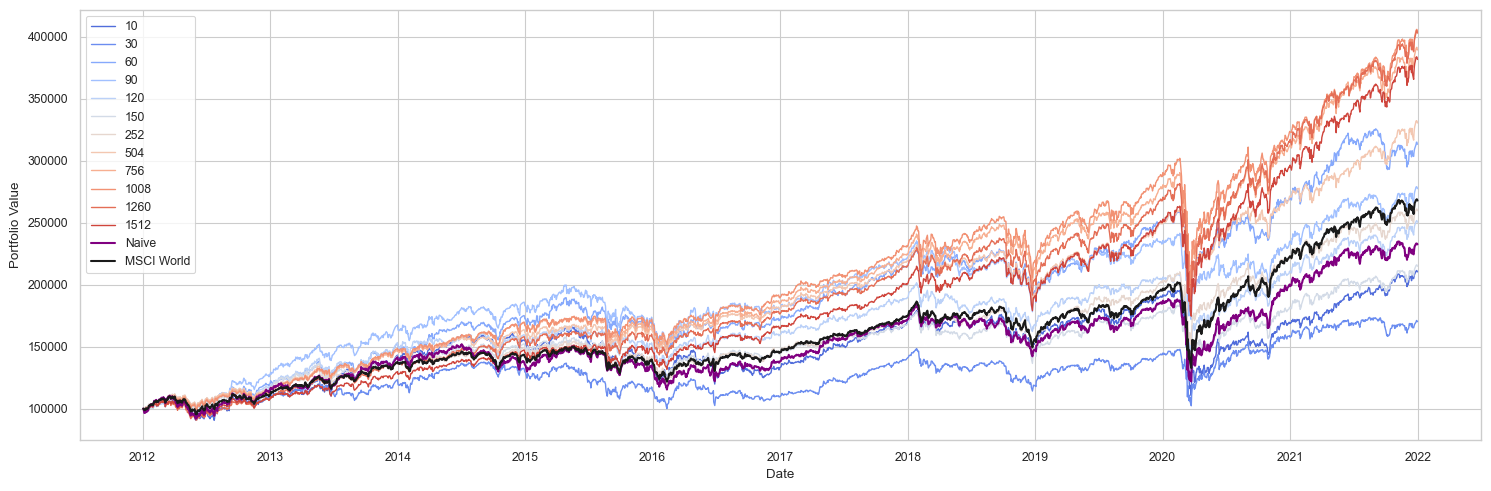

In [27]:
# eval_n_plot.plot_portfolio_val_interactive(
#     START_DATE,
#     END_DATE,
#     mvo_history_df,
#     # naive_portfolio_df=naive_portfolio_df,
#     df_ref=df_ref,
#     ref_ticker=ref_ticker,
#     initial_shares=shares_ref,
# )

eval_n_plot.plot_portfolio_val(
    START_DATE,
    END_DATE,
    mvo_history_df,
    naive_portfolio_df=naive_portfolio_df,
    df_ref=df_ref,
    ref_ticker=ref_ticker,
    initial_shares=shares_ref,
    save_dir=plt_save_dir,
    fname=f"mvo_portfolio_value_{data_src}",
)

[  10   30   60   90  120  150  252  504  756 1008 1260 1512]


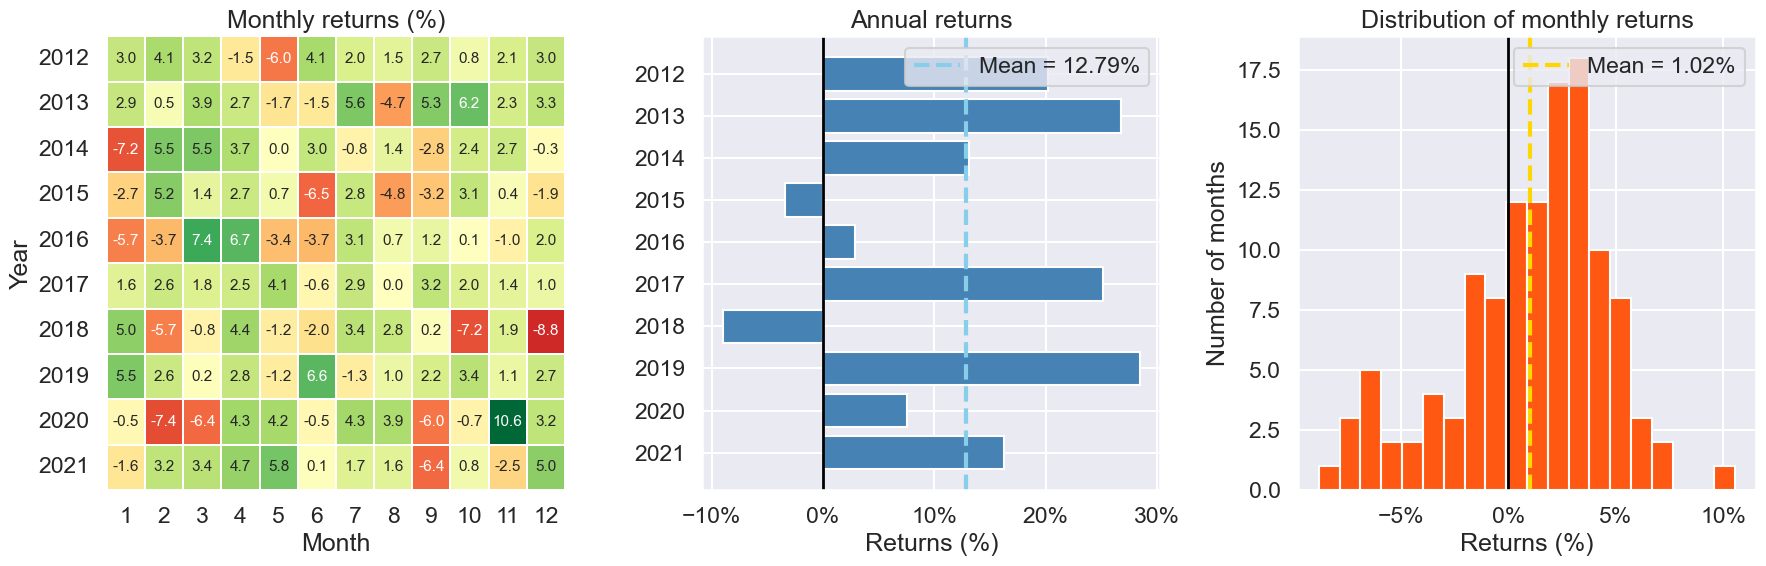

In [28]:
# Filter relevant lookback
lookback = 60
print(mvo_history_df["lookback"].unique())
focus_df = mvo_history_df[mvo_history_df["lookback"] == lookback]

monthly_pivot, annual_df = eval_n_plot.calc_monthly_annual_rets(focus_df, initial_balance)
fname = f"paper_fig4_mvo_returns_{lookback}_{data_src}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

### Buy n Hold

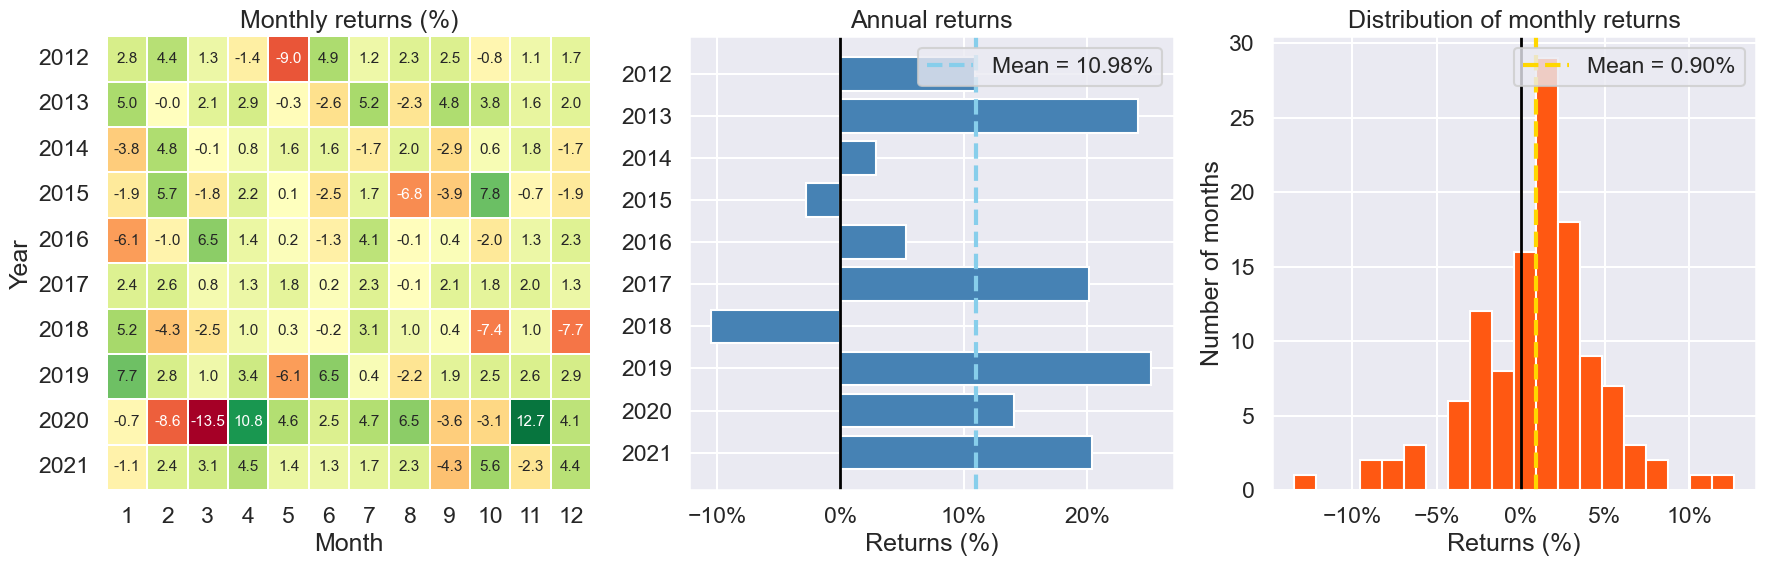

In [29]:
df_buy_n_hold = df_ref[ref_ticker].loc[(df_ref.index > START_DATE) & (df_ref.index < END_DATE)]
# make pd series df and call column : portfolio_value
df_buy_n_hold = df_buy_n_hold.to_frame(name="portfolio_value")

initial_price = df_ref[ref_ticker].loc[(df_ref.index > START_DATE)].iat[0]
monthly_pivot, annual_df = eval_n_plot.calc_monthly_annual_rets(df_buy_n_hold, initial_price)

fname = f"buy_n_hold_{data_src}"
eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

### DRL Analysis

['portfolio_10_test=2021.csv', 'portfolio_1_test=2012.csv', 'portfolio_2_test=2013.csv', 'portfolio_3_test=2014.csv', 'portfolio_4_test=2015.csv', 'portfolio_5_test=2016.csv', 'portfolio_6_test=2017.csv', 'portfolio_7_test=2018.csv', 'portfolio_8_test=2019.csv', 'portfolio_9_test=2020.csv']


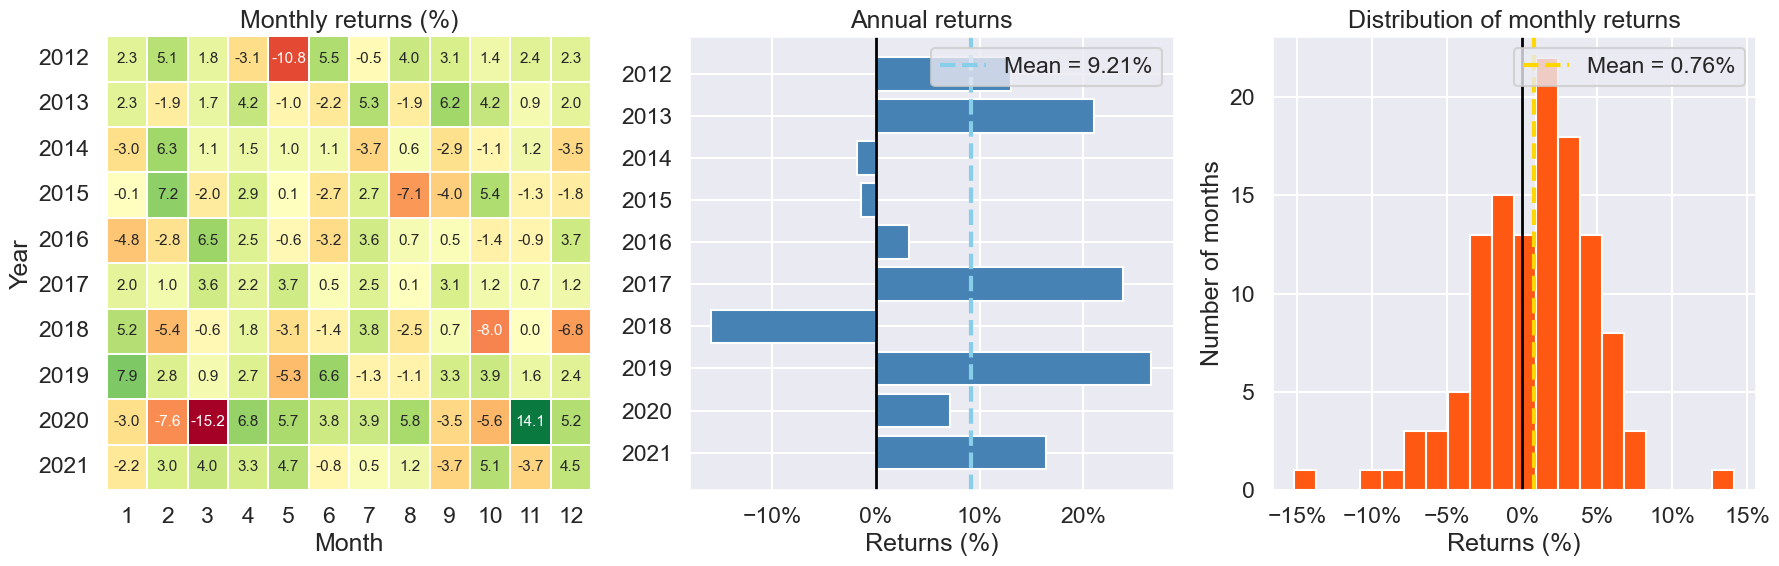

In [31]:
# get csv files in dir
# fname contains portfolio
csv_files = sorted(
    [f for f in os.listdir(drl_model_dir) if f.endswith(".csv") and "portfolio" in f]
)
print(csv_files)

# load csv files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(drl_model_dir, file))
    df.reset_index(inplace=True)
    # rename index to trading_day
    df.rename(columns={"index": "trading_day"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    dfs.append(df)

df_drl_port = pd.concat(dfs, ignore_index=True).sort_values(by=["date"]).reset_index(drop=True)

monthly_pivot, annual_df = eval_n_plot.process_drl_portfolios(df_drl_port)
fname = f"paper_fig3_drl_{drl_model_name}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

In [34]:
df_drl_port_res = df_drl_port.groupby("year", as_index=False)["portfolio_value"].last()

years = df_drl_port_res["year"].unique()
start_dates = pd.to_datetime([f"{yr}-01-01" for yr in years])
end_dates = pd.to_datetime([f"{yr}-12-31" for yr in years])

spy_start_prices = [
    df_ref.loc[df_ref.index > start, ref_ticker].iloc[0] for start in start_dates
]
spy_end_prices = [df_ref.loc[df_ref.index < end, ref_ticker].iloc[-1] for end in end_dates]

shares_start = 100_000 / pd.Series(spy_start_prices)
snp_values = shares_start * pd.Series(spy_end_prices)
df_drl_port_res[f"{data_src}_value"] = snp_values.values

df_drl_port_res

# TODO : add MVO portfolio values in other cols
# then identify best and worst performing model / agent

,year,portfolio_value,msci_value
0,2012,113066.806487,109961.882618
1,2013,121062.558147,121271.143764
2,2014,98198.870655,104607.345677
3,2015,98522.762815,98339.888099
4,2016,103220.901674,107376.290696
5,2017,123793.558924,119653.014790
6,2018,84133.737740,88412.100606
7,2019,126577.320702,125095.689449
8,2020,107112.737402,113056.113812
9,2021,116379.889227,121239.704032


In [35]:
# plot portfolio value development with hue = year
# plt.figure(figsize=(15, 5))
# sns.lineplot(x="trading_day", y="portfolio_value", hue="year", data=df_drl_port)
# plt.axhline(y=100_000, color="grey", linestyle="--")
# plt.show()

from plotly.colors import diverging, sequential
# color_sequence = diverging.RdBu
color_sequence = sequential.Viridis

fig = px.line(
    df_drl_port,
    x="trading_day",
    y="portfolio_value",
    color="year",
    color_discrete_sequence=color_sequence,
    title="Portfolio Value Development by Year"
)

# Add horizontal line at y=100_000
fig.add_hline(
    y=100_000,
    line_dash="dash",
    line_color="gray",
    annotation_text="Initial Value",
    annotation_position="top left"
)

fig.update_layout(
    height=600,
    width=1200,
    xaxis_title="Trading Day",
    yaxis_title="Portfolio Value",
    legend_title="Year"
)

fig.show()

### Table of Avg Metrics

### Fig 2 - Metrics by Year